In [1]:
from keras.losses import mse, binary_crossentropy
from tqdm.notebook import tqdm as tqdm

from keras.models import Model
from keras import backend as K
from scipy.stats import norm
from keras import metrics
from keras.layers import *

import matplotlib.pyplot as plt
from keras.utils import *
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [2]:
batch_size = 100
epochs = 200
inChannel = 1
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))
num_classes = 3

In [3]:
def sampling(args: tuple):
        # we grab the variables from the tuple
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

In [13]:
image_size = 256
input_shape = (image_size, image_size, 1)
batch_size = 100
kernel_size = 3
filters = 16
latent_dim = 128 # 隐变量取2维只是为了方便后面画图
epochs = 30


x_in = Input(shape=input_shape)
x = x_in

deep_layer = 3

for i in range(deep_layer):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# 备份当前shape，等下构建decoder的时候要用
shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(latent_dim, activation='relu')(x)
# # 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 解码层，也就是生成器部分
# 先搭建为一个独立的模型，然后再调用模型
latent_inputs = Input(shape=(latent_dim,))
# label_inputs = Input(shape=(num_classes,))
# x = Concatenate()([latent_inputs])
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(deep_layer):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same')(x)

# 搭建为一个独立的模型
decoder = Model(latent_inputs, outputs)

x_out = decoder(z)

# 建立模型
vae = Model(x_in , x_out)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.binary_crossentropy(x_in, x_out), axis=[1, 2, 3])
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 32) 320         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 64)   18496       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 128)  73856       conv2d_11[0][0]                  
____________________________________________________________________________________________

C:\Users\Lab620\Anaconda3\envs\lawrence\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output model_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_5.
  'be expecting any data to be passed to {0}.'.format(name))


In [14]:
# dir_path = "10_20200901_Original"

# mapping_data = json.load(open(f"Dental_Data/PBL/{dir_path}/mapping.json", "r"))
# filter_data = { path: max(list(map(int, state))) for path, state in mapping_data.items() if max(list(map(int, state))) >= 0 }

directory = [ 
                "Dental_Data/PBL/10_20200901", 
                "Dental_Data/PBL/10_20200901_Flip", 
                "Dental_Data/PBL/10_clahe_20200901", 
                "Dental_Data/PBL/10_clahe_20200901_Flip"
            ]

directory = [ i + "/mapping.json" for i in directory]
argscale_num = len(directory) * 20

def json_2_dataframe_PBL(dataframe, data, mode=None):
        data_dict, counter = collections.OrderedDict(), 0
        
        molar = [1, 2, 3, 14, 15, 16, 17, 18, 19, 30, 31, 32]
        premolar = [ 4, 5, 12, 13, 20, 21, 29, 30 ]
        
        for path, state in tqdm(data.items()):
                item = { "Path": path, "State": state, "Class": state-1 if state > 1 else 0  }
                path_split = path.split("_")
                
                item["tooth_num"] = int(path_split[-2])
                
                if (mode == "molar" and (item["tooth_num"] not in molar))\
                    or (mode == "premolar" and (item["tooth_num"] not in premolar) ): continue 
                        
                item["angle"] = int(path_split[-1].split(".")[0])
                data_dict[counter] = item
                counter += 1        
        dataframe = dataframe.from_dict(data_dict, "index")
        return dataframe

from Dental_Tool.Data_processing import *
from Dental_Tool.Dental_Model import *
from Dental_Tool.Process_results import *
from Dental_Tool.Dataloader import *
from Dental_Tool.KFold_v3 import *

data = load_json(directory, interdental=False)
dataset = json_2_dataframe_PBL(data, mode="molar")
dataset
# dataset = pd.DataFrame(columns=PBL_Columns)
# dataset = json_2_dataframe_PBL(dataset, filter_data, mode="premolar")

# severe = dataset[dataset["Class"] == 2]
# severe

,Path,State,Class,source,tooth_num,angle
0,Dental_Data/PBL/10_20200901/15-53-19-666_00040...,3,2,NN_191024_151631_BE78BA_2,2,-10
1,Dental_Data/PBL/10_20200901_Flip/15-53-19-666_...,3,2,NN_191024_151631_BE78BA_2,2,-10
2,Dental_Data/PBL/10_clahe_20200901/16-31-09-808...,3,2,NN_191024_151631_BE78BA_2,2,-10
3,Dental_Data/PBL/10_clahe_20200901_Flip/16-31-0...,3,2,NN_191024_151631_BE78BA_2,2,-10
4,Dental_Data/PBL/10_20200901/15-53-19-697_00040...,3,2,NN_191024_151631_BE78BA_2,2,-9
...,...,...,...,...,...,...
106475,Dental_Data/PBL/10_clahe_20200901_Flip/17-03-1...,1,0,NN_140521_095055_C0A4EA_19,19,8
106476,Dental_Data/PBL/10_20200901/16-30-47-021_S4210...,1,0,NN_140521_095055_C0A4EA_19,19,9
106477,Dental_Data/PBL/10_20200901_Flip/16-30-47-021_...,1,0,NN_140521_095055_C0A4EA_19,19,9
106478,Dental_Data/PBL/10_clahe_20200901/17-03-16-474...,1,0,NN_140521_095055_C0A4EA_19,19,9


In [15]:
def load_images(path_list, resize):
        X = []
        for path in tqdm(path_list):
                image = cv2.imread(path, 0)
                image = cv2.resize(image, resize)
                image = image.astype("float32") / 255.0
#                 image = image - np.mean(image)
                image = np.expand_dims(image, axis=2)
                X.append(image)
        return np.array(X)


for train, valid, test, train_gen, valid_gen, test_gen in \
    K_Fold_balance_data_generator(dataset, argscale_num, batch_size=32, k_fold_num=5):
        
        x_train, y_train = load_images(train["Path"], (image_size, image_size)), to_categorical(train["Class"], num_classes)
        x_valid, y_valid = load_images(valid["Path"], (image_size, image_size)), to_categorical(valid["Class"], num_classes)
        x_test, y_test = load_images(test["Path"], (image_size, image_size)), to_categorical(test["Class"], num_classes)
        break

stage 0: 10400, stage 1: 27120, stage 2: 17360, stage 3: 8640
stage 0: 3600, stage 1: 9120, stage 2: 5680, stage 3: 2880
stage 0: 3520, stage 1: 9200, stage 2: 5840, stage 3: 3120


In [30]:
vae.fit(x_train,
        shuffle=True,
        epochs=20000,
        batch_size=100,
        validation_data=(x_valid, None))

Train on 25920 samples, validate on 8640 samples
Epoch 1/20000
25920/25920 [==============================] - 66s 3ms/step - loss: 38375.3353 - val_loss: 39506.9038
Epoch 2/20000
25920/25920 [==============================] - 67s 3ms/step - loss: 38372.5696 - val_loss: 39634.9482
Epoch 3/20000
25920/25920 [==============================] - 67s 3ms/step - loss: 38368.5201 - val_loss: 39606.1596
Epoch 4/20000
25920/25920 [==============================] - 68s 3ms/step - loss: 38365.1314 - val_loss: 39702.1215
Epoch 5/20000
25920/25920 [==============================] - 68s 3ms/step - loss: 38360.7037 - val_loss: 39705.9797
Epoch 6/20000
25920/25920 [==============================] - 68s 3ms/step - loss: 38357.4827 - val_loss: 39563.0322
Epoch 7/20000
25920/25920 [==============================] - 68s 3ms/step - loss: 38353.6915 - val_loss: 39567.2292
Epoch 8/20000
25920/25920 [==============================] - 68s 3ms/step - loss: 38350.0543 - val_loss: 39542.6253
Epoch 9/20000
25920/259

KeyboardInterrupt: 

In [ ]:
# # 构建encoder，然后观察各个数字在隐空间的分布
# encoder = Model(x_in, z_mean)

# x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
# plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
# plt.colorbar()
# plt.show()

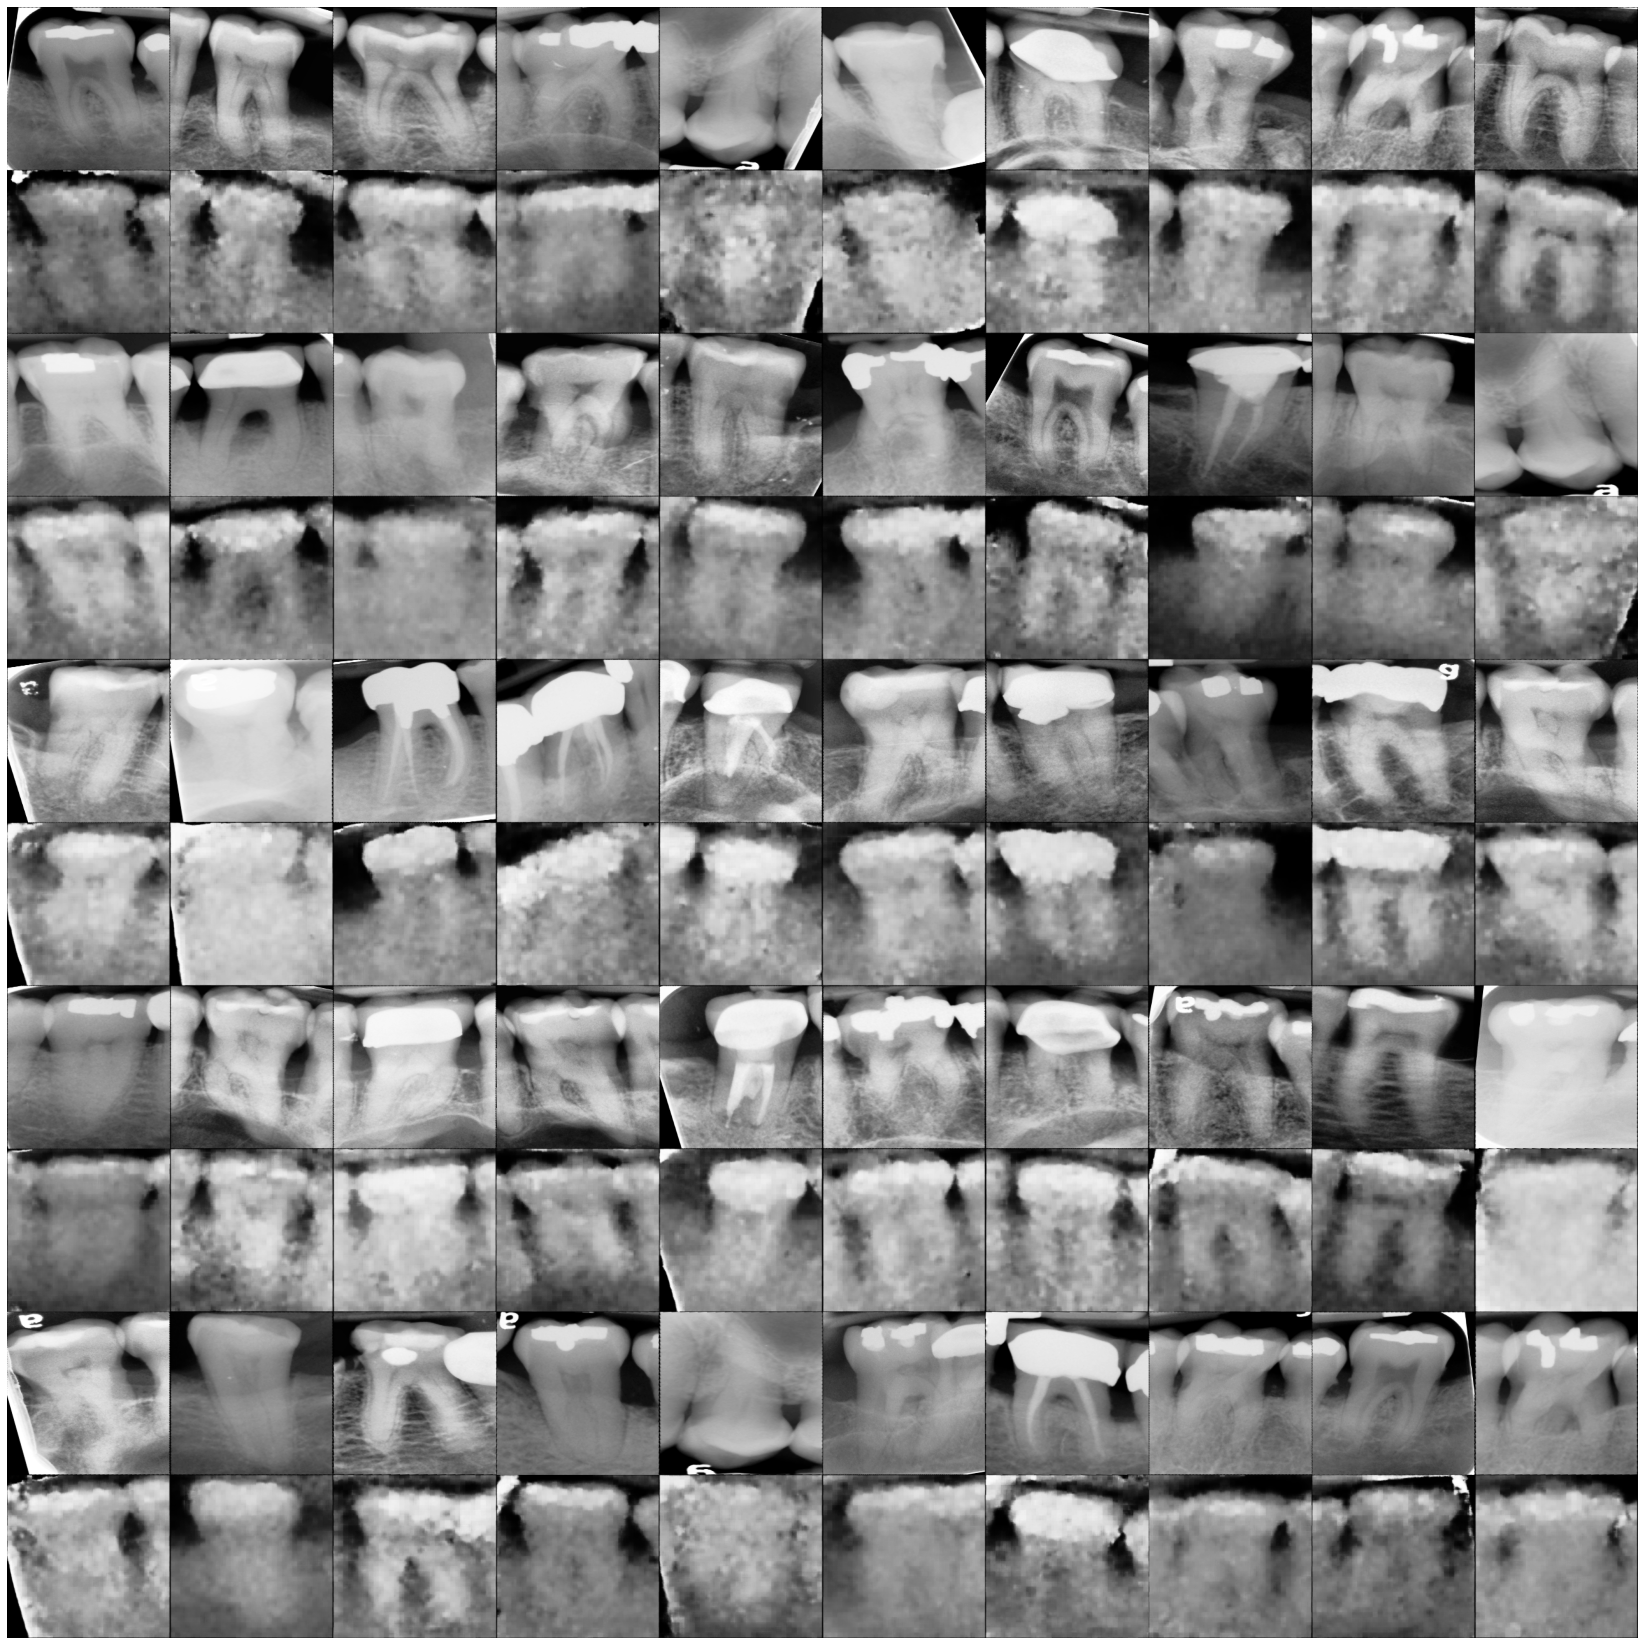

In [46]:
decoded_imgs = vae.predict(x_test)

n = 10
image_size = 256
figure = np.zeros((image_size * n, image_size * n))

# [0, 0] [0, 1] [0, 2]
# [1, 0] [1, 1] [1, 2]
# [2, 0] [2, 1] [2, 2]

count = 0
for i in range(0, n, 2):
        for j in range(0, n):
                digit = decoded_imgs[count].reshape(image_size, image_size)
                original = x_test[count].reshape(image_size, image_size)
                
                figure[i * image_size: (i + 1) * image_size,
                       j * image_size: (j + 1) * image_size] = original
                
                figure[(i+1) * image_size: (i + 2) * image_size,
                        j * image_size: (j + 1) * image_size] = digit
                count += 1
                
#     # Display original
#     ax = plt.subplot(2, n, i)
#     plt.imshow(x_test[i].reshape(image_size, image_size))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

#     # Display reconstruction
#     ax = plt.subplot(2, n, i + n)
#     plt.imshow(decoded_imgs[i].reshape(image_size, image_size))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

plt.figure(figsize=(30, 30))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

In [ ]:
# # 观察隐变量的两个维度变化是如何影响输出结果的
# n = 15  # figure with 15x15 digits
# digit_size = 128
# figure = np.zeros((digit_size * n, digit_size * n))

# #用正态分布的分位数来构建隐变量对
# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# classes = np.eye(3).tolist()
# want_class = 2
# print(classes[want_class])
# print(np.array([[xi, yi], classes[want_class]]).shape )
# print([xi, yi])

# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         x_decoded = decoder.predict( [ [[xi], [yi]], classes[want_class]] ) 
#         digit = x_decoded[0].reshape(digit_size, digit_size)
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit

# # for i in range(n):
# #     for j in range(n):
# # #         z_sample = np.random.multivariate_normal(mean=[0] * 128, cov=np.identity(128), size=128)
# # #         print(z_sample.shape)
# #         z_sample = np.random.rand(128, 128)
# # #         print(z_sample.shape)
# #         x_decoded = decoder.predict(z_sample)
# #         digit = x_decoded[0].reshape(digit_size, digit_size)
# #         figure[i * digit_size: (i + 1) * digit_size,
# #                j * digit_size: (j + 1) * digit_size] = digit

# plt.figure(figsize=(30, 30))
# plt.imshow(figure, cmap='Greys_r')
# plt.show()

In [54]:
def vae_classifier(input_shape):
#         flat = Flatten()(enco)
#         x = Input(shape=(original_dim,))
        x_in = Input(shape=input_shape)
        x = x_in
        deep_layer = 3
        filters = 16
        kernel_size=3
        
        for i in range(deep_layer):
            filters *= 2
            x = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       activation='relu',
                       strides=2,
                       padding='same')(x)

        # 备份当前shape，等下构建decoder的时候要用
        shape = K.int_shape(x)

        x = Flatten()(x)
        x = Dense(latent_dim, activation='relu')(x)
#         # 算p(Z|X)的均值和方差
#         z_mean = Dense(latent_dim)(x)
#         z_log_var = Dense(latent_dim)(x)

#         # 重参数层，相当于给输入加入噪声
#         z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
        den = Dense(64, activation='relu')(x)
        out = Dense(3, activation='softmax')(den)
        
        model = Model(x_in, out)
        return model

    


full_model = vae_classifier((image_size, image_size, 1))
# for l1,l2 in zip(full_model.layers[:3],vae.layers[0:3]):
#     l1.set_weights(l2.get_weights())

full_model.summary()

for l1,l2 in zip(full_model.layers[:6], vae.layers[:6]):
        l1.set_weights(l2.get_weights())
        print(f"Setting {l2} to {l1}")


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten_13 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16777344  
_________________________________________________________________
dense_37 (Dense)             (None, 64)                825

In [55]:
for layer in full_model.layers[:6]:
        layer.trainable = False
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [56]:
classify_train = full_model.fit(x_train, y_train, batch_size=100,epochs=10,verbose=1,validation_data=(x_valid, y_valid))

Train on 25920 samples, validate on 8640 samples
Epoch 1/10
25920/25920 [==============================] - 9s 353us/step - loss: 0.9238 - accuracy: 0.5448 - val_loss: 0.9528 - val_accuracy: 0.5123
Epoch 2/10
25920/25920 [==============================] - 9s 339us/step - loss: 0.8321 - accuracy: 0.6010 - val_loss: 0.9965 - val_accuracy: 0.5185
Epoch 3/10
25920/25920 [==============================] - 9s 338us/step - loss: 0.7875 - accuracy: 0.6305 - val_loss: 1.0188 - val_accuracy: 0.5093
Epoch 4/10
25920/25920 [==============================] - 9s 338us/step - loss: 0.7446 - accuracy: 0.6582 - val_loss: 1.0378 - val_accuracy: 0.4992
Epoch 5/10
25920/25920 [==============================] - 9s 337us/step - loss: 0.7092 - accuracy: 0.6816 - val_loss: 1.0783 - val_accuracy: 0.4991
Epoch 6/10
25920/25920 [==============================] - 9s 337us/step - loss: 0.6768 - accuracy: 0.7009 - val_loss: 1.1242 - val_accuracy: 0.4985
Epoch 7/10
25920/25920 [==============================] - 9s 33

In [53]:
full_model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

9360/9360 [==============================] - 2s 261us/step


[2.9182027430615873, 0.5620726346969604]